
# Estimating the Effect of Schooling on Wages: Intrumental Variables Application

### Summary of Contents:
1. [Introduction](#intro)
2. [NLSYM Dataset](#data)
3. [A Gentle Start: The Naive Approach](#naive)
4. [Using Instrumental Variables: 2SLS](#2sls)
5. [Bonus: Deep Instrumental Variables](#deepiv)


**Important:** This notebook is an end-to-end solution for this problem. If you are looking for notebook with some room for experimentation, look for the same file name without the "Complete" suffix.

# 1. Introduction <a class="anchor" id="intro"></a>

To measure true causal effects of a treatment $T$ on an outcome $Y$ from observational data, we need to record all features $X$ that might influence both $T$ and $Y$. These $X$'s are called confounders. 

When some confounders are not recorded in the data, we might get biased estimates of the treatment effect. Here is an example:
* Children of high-income parents might attain higher levels of education (e.g. college) since they can afford it
* Children of high-income parents might also obtain better paying jobs due to parents' connections and knowledge
* At first sight, it might appear as if education has an effect on income, when in fact this could be fully explained by family background

There are several reasons for not recording all possible confounders, such as incomplete data or a confounder that is difficult to quantify (e.g. parental involvement). However, not all is lost! In cases such as these, we can use instrumental variables $Z$, features that affect the outcome only through their effect on the treatment. 

In this notebook, we use a real-world problem to show how treatment effects can be extracted with the help of instrumental variables. 

# 2. NLSYM Dataset <a class="anchor" id="data"></a>

The **causal impact of schooling on wages** had been studied at length. Although it is generally agreed that there is a positive impact, it is difficult to measure this effect precisely. The core problem is that education levels are not assigned at random in the population and we cannot record all possible confounders. (Think about the value parents assign to education. How would you quantify how valuable parents think their children's education is?). 

<img src="https://straubroland.files.wordpress.com/2010/12/education_technology-resized-600.png" width=400px/>

To get around this issue, we can use **proximity to a 4-year college** as an instrumental variable. Having a college nearby can allow individuals (especially low-income ones) to complete more years of education. Hence, if there was a positive treatment effect, we would expect these individuals to have higher wages on average. Note that college proximity is a valid IV since it does not affect wages directly.  

We use data from the National Longitudinal Survey of Young Men (NLSYM, 1966) to estimate the average treatment effect (ATE) of education on wages (see also [Card, 1999](https://www.nber.org/papers/w4483)). The NLSYM data contains entries from men ages 14-24 that were interviewed in 1966 and again in 1976. 

The dataset contains the following variables:
* $Y$ (outcome): wages (log)
* $T$ (treatment): years of schooling
* $Z$ (IV): proximity to a 4-year college (binary)
* $X$ (heterogeneity): e.g. parental education
* $W$ (controls): e.g. family composition, location, etc.

The world can then be modelled as:
$$
\begin{align}
Y & = \theta(X) \cdot T + f(W) + \epsilon\\
T & = g(Z, W) + \eta
\end{align}
$$
where $\epsilon, \eta$ are uncorrelated error terms.

In [9]:
# Python imports
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from econml.dml import LinearDMLCateEstimator
from sklearn.linear_model import LassoCV
from econml.inference import BootstrapInference

# EconML imports
from econml.dml import DMLCateEstimator
from econml.two_stage_least_squares import NonparametricTwoStageLeastSquares
from econml.deepiv import DeepIVEstimator

%matplotlib inline

In [2]:
!ls

data
Deep IV Examples.ipynb
Double Machine Learning Examples.ipynb
Hands-on Part I -- Estimating Price Elasticity of Orange Juice Demand - Complete.ipynb
Hands-on Part I -- Estimating Price Elasticity of Orange Juice Demand.ipynb
Hands-on Part II -- Estimating the Effect of Schooling on Wages - Complete.ipynb
Hands-on Part II -- Estimating the Effect of Schooling on Wages.ipynb
Metalearners Examples.ipynb
oj_large.csv
Orthogonal Random Forest Examples.ipynb
Our_Model.ipynb
README.md
requirements.txt


In [3]:
# Data processing
df = pd.read_csv("data/card.csv", dtype=float)
# Filter out individuals with low education levels (outliers)
data_filter = df['educ'].values >= 6
# Define some variables
T = df['educ'].values[data_filter]
Z = df['nearc4'].values[data_filter]
Y = df['lwage'].values[data_filter]

# Impute missing values with mean, add dummy columns
# Filter outliers (interviewees with less than 6 years of education)
X_df = df[['exper', 'expersq']].copy()
X_df['fatheduc'] = df['fatheduc'].fillna(value=df['fatheduc'].mean())
X_df['fatheduc_nan'] = df['fatheduc'].isnull() * 1
X_df['motheduc'] = df['motheduc'].fillna(value=df['motheduc'].mean())
X_df['motheduc_nan'] = df['motheduc'].isnull() * 1
X_df[['momdad14', 'sinmom14', 'reg661', 'reg662',
        'reg663', 'reg664', 'reg665', 'reg666', 'reg667', 'reg668', 'reg669', 'south66']] = df[['momdad14', 'sinmom14', 
        'reg661', 'reg662','reg663', 'reg664', 'reg665', 'reg666', 'reg667', 'reg668', 'reg669', 'south66']]
X_df[['black', 'smsa', 'south', 'smsa66']] = df[['black', 'smsa', 'south', 'smsa66']]
columns_to_scale = ['fatheduc', 'motheduc', 'exper', 'expersq']
# Scale continuous variables
scaler = StandardScaler()
X_df[columns_to_scale] = scaler.fit_transform(X_df[columns_to_scale])
X = X_df.values[data_filter]

In [4]:
# Explore data
X_df.head()

,exper,expersq,fatheduc,fatheduc_nan,motheduc,motheduc_nan,momdad14,sinmom14,reg661,reg662,...,reg665,reg666,reg667,reg668,reg669,south66,black,smsa,south,smsa66
0,1.725159,1.896133,5.439188e-16,1,0.000000,1,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
1,0.034739,-0.172321,-6.134540e-01,0,-0.786159,0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,1.725159,1.896133,1.223740e+00,0,0.553046,0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0.276228,0.052254,3.051432e-01,0,0.553046,0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,1.725159,1.896133,-6.134540e-01,0,-1.120960,0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


# 3. A Gentle Start: The Naive Approach <a class="anchor" id="naive"></a>

Let's assume we know nothing about instrumental variables and we want to measure the treatment effect of schooling on wages. We can apply an IV-free method like Double Machine Learning (DML) to do this and extract a treatment effect. 

In [10]:
# dml_est = DMLCateEstimator(model_y=RandomForestRegressor(n_estimators=100), 
#                            model_t=RandomForestRegressor(n_estimators=100))


dml_est = LinearDMLCateEstimator(model_y=LassoCV(), model_t=LassoCV())
    

In [11]:
dml_est.fit(Y, T, X)
dml_ate = dml_est.effect(X).mean()

/home/dtd/.conda/envs/phd_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/dtd/.conda/envs/phd_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/dtd/.conda/envs/phd_env/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07136824549658627, tolerance: 0.020362262857373824
  tol, rng, random, positive)
/home/dtd/.conda/envs/phd_env/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You mig

/home/dtd/.conda/envs/phd_env/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1050646031898026, tolerance: 0.02006073124866469
  tol, rng, random, positive)
/home/dtd/.conda/envs/phd_env/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06923505177313416, tolerance: 0.02006073124866469
  tol, rng, random, positive)
/home/dtd/.conda/envs/phd_env/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06160867201320741, tolerance: 0.02006073124866469
  tol, rng, random, positive)
/home/dtd/.conda/envs/phd_env/lib/python3.7/site-packages/sklearn/linear_model/coordinate_desce

In [12]:
print("Average treatment effect: {0:.3f}".format(dml_ate))

Average treatment effect: 0.069


This treatment effect is smaller than other values obtained in literature via IV. Why could that be? 

Because DML (like all IV-free methods) assumes that the residual errors are uncorrelated (i.e. $Y - \hat{Y}$ is uncorrelated with $T - \hat{T}$). Let's test this assumption:

In [13]:
# Split data in 2 parts for cross-fitting 
# We do this to avoid over-fitting
T_res, Y_res = np.zeros(T.shape[0]), np.zeros(Y.shape[0])
kf = KFold(n_splits=2, shuffle=True)
for train_index, test_index in kf.split(X):
    T_res[test_index] = T[test_index] - \
    RandomForestRegressor(n_estimators=100).fit(X[train_index], T[train_index]).predict(X[test_index])
    Y_res[test_index] = Y[test_index] - \
    RandomForestRegressor(n_estimators=100).fit(X[train_index], Y[train_index]).predict(X[test_index])

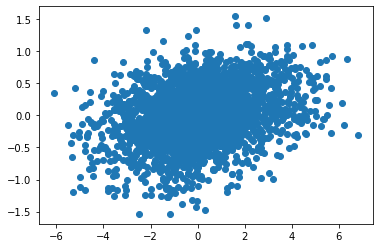

In [14]:
plt.scatter(T_res, Y_res)
plt.show()

In [15]:
corr_coeficient = pearsonr(T_res, Y_res)[0]
print("Correlation coefficient between T and Y errors: {0:.2f}".format(corr_coeficient))

Correlation coefficient between T and Y errors: 0.31


The correlation coefficient between the residuals is quite large, which means that there is some unobserved variables that affect both $T$ and $Y$. To get an accurate estimate in this case, we need to use IVs. 

# 4. Using Intrumental Variables: 2SLS <a class="anchor" id="2sls"></a>

Two stage least square regression procedure (2SLS):
1. Fit a model $T \sim W, Z$
2. Fit a linear model $Y \sim \hat{T}$ where $\hat{T}$ is the prediction of the model in step 1.
The coefficient from 2. above is the average treatment effect.

If interested in heterogeneous treatment effects, fit a model $Y \sim \hat{T}\otimes h(X)$, where $h(X)$ is a chosen featurization of the treatment effect. 

For more information, see the `econml` [documentation](https://econml.azurewebsites.net).

In [16]:
# For average treatment effects, X is a column of 1s
W = X
Z = Z.reshape(-1, 1)
T = T.reshape(-1, 1)
X_ate = np.ones_like(Z)

In [17]:
# We apply 2SLS from the EconML library
two_sls_est = NonparametricTwoStageLeastSquares(
    t_featurizer=PolynomialFeatures(degree=1, include_bias=False),
    x_featurizer=PolynomialFeatures(degree=1, include_bias=False),
    z_featurizer=PolynomialFeatures(degree=1, include_bias=False),
    dt_featurizer=None) # dt_featurizer only matters for marginal_effect

In [18]:
two_sls_est.fit(Y, T, X_ate, W, Z)
two_sls_ate = two_sls_est.effect(np.ones((1,1)))[0]

In [19]:
print("Average treatment effect: {0:.3f}".format(two_sls_ate))

Average treatment effect: 0.142


# 5. Bonus: Deep Instrumental Variables <a class="anchor" id="deepiv"></a>

For very flexible, but fully non-parametric IV methods, you can use neural networks for the two models in 2SLS and a mixture of gaussians for the featurizer $h(X)$. In `econml`, this method is called DeepIV. 

The NLSYM dataset is small (on neural net scale) so applying DeepIV is a bit of a stretch. Nevertheless, we apply DeepIV the NLSYM data as an example. You should not read too much into the results. 

In [20]:
# Define treatment model, T ~ X, Z
treatment_model = keras.Sequential([keras.layers.Dense(64, activation='relu', input_shape=(X.shape[1] + 1,)),
                                    keras.layers.Dropout(rate=0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(rate=0.17),
                                    keras.layers.Dense(1)])
# Define outcome model, Y ~ T_hat, X
response_model = keras.Sequential([keras.layers.Dense(64, activation='relu', input_shape=(X.shape[1] + 1,)),
                                   keras.layers.Dropout(rate=0.17),
                                   keras.layers.Dense(32, activation='relu'),
                                   keras.layers.Dropout(rate=0.17),
                                   keras.layers.Dense(1)])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [15]:
keras_fit_options = { "epochs": 30,
                      "validation_split": 0.3,
                      "callbacks": [keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)]}

deepIvEst = DeepIVEstimator(n_components = 10, # number of gaussians in our mixture density network
                            m = lambda z, x : treatment_model(keras.layers.concatenate([z,x])), # treatment model
                            h = lambda t, x : response_model(keras.layers.concatenate([t,x])),  # response model
                            n_samples = 1, # number of samples to use to estimate the response
                            use_upper_bound_loss = False, # whether to use an approximation to the true loss
                            n_gradient_samples = 1, # number of samples to use in second estimate of the response (to make loss estimate unbiased)
                            optimizer='adam', # Keras optimizer to use for training - see https://keras.io/optimizers/ 
                            first_stage_options = keras_fit_options, # options for training treatment model
                            second_stage_options = keras_fit_options) # options for training response model

In [16]:
deepIvEst.fit(Y, T, X, Z)
deepIv_effect = deepIvEst.effect(X)

Train on 2093 samples, validate on 898 samples
Epoch 1/30
2093/2093 [==============================] - 2s 999us/step - loss: 12.9197 - val_loss: 5.2148
Epoch 2/30
2093/2093 [==============================] - 0s 176us/step - loss: 5.2703 - val_loss: 4.5710
Epoch 3/30
2093/2093 [==============================] - 0s 165us/step - loss: 4.6385 - val_loss: 4.1145
Epoch 4/30
2093/2093 [==============================] - 0s 175us/step - loss: 4.1656 - val_loss: 3.7890
Epoch 5/30
2093/2093 [==============================] - 0s 132us/step - loss: 3.8190 - val_loss: 3.4813
Epoch 6/30
2093/2093 [==============================] - 0s 142us/step - loss: 3.5759 - val_loss: 3.3215
Epoch 7/30
2093/2093 [==============================] - 0s 144us/step - loss: 3.4377 - val_loss: 3.2289
Epoch 8/30
2093/2093 [==============================] - 0s 150us/step - loss: 3.3842 - val_loss: 3.1585
Epoch 9/30
2093/2093 [==============================] - 0s 117us/step - loss: 3.2949 - val_loss: 3.0972
Epoch 10/30
2093

In [17]:
print("Average treatment effect: {0:.3f}".format(deepIv_effect.mean()))

Average treatment effect: 0.172


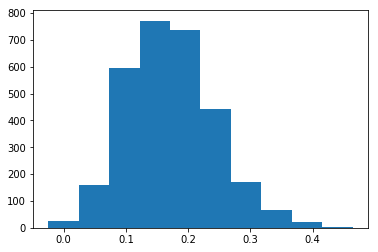

In [18]:
# Heterogeneity of treatment effects
plt.hist(deepIv_effect)
plt.show()